In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model


Bad key "text.kerning_factor" on line 4 in
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Read the train/validation and test data

In [2]:
name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/Cosmos_Data/automated_cosmos_tweety_to_file"
#_TRAINING.csv"
train_val_df = pd.read_csv(name + '_TRAINING.csv')
test_df = pd.read_csv(name + '_TESTING.csv')
model_save = './model/' + name  + '_no_none_class/'

In [3]:
train_val_df.shape

(65867, 6)

In [4]:
train_val_df["filename"] = train_val_df["file"].apply(lambda x: x.split("/")[-1])
train_val_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLE RATE,MANUAL ID,filename
0,10,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,24.906977,26.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
1,14,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,30.232558,30.930233,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
2,21,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,50.627907,52.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
3,22,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,60.488372,62.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
4,29,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.860465,1.325581,44100,Tolmomyias sulphurescens,XC100068 - Yellow-olive Flatbill - Tolmomyias ...


In [5]:
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.0,3.000000,44100,bird
1,1,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,3.0,6.000000,44100,bird
2,2,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,6.0,9.000000,44100,bird
3,3,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,9.0,9.299592,44100,bird
4,4,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.0,3.000000,44100,Turdus leucomelas


In [6]:
test_df["filename"] = test_df["file"].apply(lambda x: x.split("/")[-1])
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.0,3.000000,44100,bird,XC100864 - Rufous-collared Sparrow - Zonotrich...
1,1,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,3.0,6.000000,44100,bird,XC100864 - Rufous-collared Sparrow - Zonotrich...
2,2,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,6.0,9.000000,44100,bird,XC100864 - Rufous-collared Sparrow - Zonotrich...
3,3,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,9.0,9.299592,44100,bird,XC100864 - Rufous-collared Sparrow - Zonotrich...
4,4,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.0,3.000000,44100,Turdus leucomelas,XC101469 - Pale-breasted Thrush - Turdus leuco...


In [7]:
train_val_df = train_val_df[~train_val_df["filename"].isin(test_df["filename"])]
test_df.merge(train_val_df, left_on="filename", right_on="filename")

,Unnamed: 0_x,file_x,start_time_x,end_time_x,SAMPLING RATE,MANUAL ID_x,filename,Unnamed: 0_y,file_y,start_time_y,end_time_y,SAMPLE RATE,MANUAL ID_y


### Check counts of the different classes in both the dataframes

In [8]:
no_bird = train_val_df[train_val_df["MANUAL ID"] == "other"].sample(4000)
train_val_df = train_val_df[~train_val_df["MANUAL ID"].isin(["other"])]
train_val_df = train_val_df.append(no_bird)
train_val_df

,Unnamed: 0,file,start_time,end_time,SAMPLE RATE,MANUAL ID,filename
0,10,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,24.906977,26.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
1,14,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,30.232558,30.930233,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
2,21,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,50.627907,52.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
3,22,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,60.488372,62.000000,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
4,29,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.860465,1.325581,44100,Tolmomyias sulphurescens,XC100068 - Yellow-olive Flatbill - Tolmomyias ...
...,...,...,...,...,...,...,...
39865,825,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.000000,35.918400,44100,other,Amazona-ochrocephala-12092.wav_0.0s_35.9184s.wav
15746,3440,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.000000,239.700000,44100,other,Cacicus-chrysonotus-171777.wav_0.0s_239.7s.wav
60359,24305,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.000000,42.312000,44100,other,Sclerurus-albigularis-475900.wav_0.0s_42.312s.wav
16489,4242,C:/Users/siloux/Desktop/E4E/passive-acoustic-b...,0.000000,17.972200,44100,other,Capito-auratus-275811.wav_0.0s_17.9722s.wav


In [9]:
species = np.unique(train_val_df['MANUAL ID'])
def fix_classes(label):
    if (not label in species):
        return "other"
    return label
test_df['MANUAL ID'] = test_df["MANUAL ID"].apply(fix_classes)

In [10]:
train_val_df['MANUAL ID'].value_counts()

other                       4000
Zonotrichia capensis        2049
Ramphastos tucanus          2040
Turdus leucomelas           1851
Microcerculus marginatus    1521
Tolmomyias sulphurescens    1497
Xiphorhynchus guttatus      1227
Trogon viridis              1029
Myioborus miniatus           603
Thraupis episcopus           544
Celeus grammicus             326
Name: MANUAL ID, dtype: int64

In [11]:
test_df['MANUAL ID'].value_counts()

other                       3167
Ramphastos tucanus           547
Turdus leucomelas            511
Trogon viridis               426
Zonotrichia capensis         414
Myioborus miniatus           406
Xiphorhynchus guttatus       390
Tolmomyias sulphurescens     376
Microcerculus marginatus     346
Thraupis episcopus           226
Celeus grammicus             165
Name: MANUAL ID, dtype: int64

### Changing species' names to a simpler version for convenience

In [12]:
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = 'Toucan'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Flycatcher'), 'MANUAL ID'] = 'Flycatcher'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Thrush'), 'MANUAL ID'] = 'Thrush'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = 'Vireo'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = 'Antwren'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = 'Tanager'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = 'Kingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = 'Tody-Tyrant'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = 'Hummingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = 'Antshrike'

### Remove rows from dataframes which are not the species of our interest

In [13]:
classes = np.unique(test_df['MANUAL ID'])#['Antwren', 'Antshrike', 'Toucan', 'Vireo', 'Kingbird', 'Tody-Tyrant', 'None']
train_val_df = train_val_df[train_val_df["MANUAL ID"].isin(classes)]
test_df = test_df[test_df["MANUAL ID"].isin(classes)]
print('Classwise Counts for train/val data:')
print(train_val_df['MANUAL ID'].value_counts())
print('\nClasswise  Counts for test data:')
print(test_df['MANUAL ID'].value_counts())

Classwise Counts for train/val data:
other                       4000
Zonotrichia capensis        2049
Ramphastos tucanus          2040
Turdus leucomelas           1851
Microcerculus marginatus    1521
Tolmomyias sulphurescens    1497
Xiphorhynchus guttatus      1227
Trogon viridis              1029
Myioborus miniatus           603
Thraupis episcopus           544
Celeus grammicus             326
Name: MANUAL ID, dtype: int64

Classwise  Counts for test data:
other                       3167
Ramphastos tucanus           547
Turdus leucomelas            511
Trogon viridis               426
Zonotrichia capensis         414
Myioborus miniatus           406
Xiphorhynchus guttatus       390
Tolmomyias sulphurescens     376
Microcerculus marginatus     346
Thraupis episcopus           226
Celeus grammicus             165
Name: MANUAL ID, dtype: int64


### Convert the train/val and test data to one-hot representations of the classes

In [14]:
# Train/val
one_hot_labels, train_classes = categorical_to_one_hot(train_val_df[['MANUAL ID']].values)
train_val_df = pd.DataFrame(index=train_val_df['file'],data=one_hot_labels,columns=train_classes)

# Test
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

### Split the trainining/validation dataframe into training and validation sets

In [15]:
train_df, valid_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [16]:
print("Number of training examples : ", train_df.shape[0])
print("Number of validation examples : ", valid_df.shape[0])
print("Number of test examples : ", test_df.shape[0])

Number of training examples :  13349
Number of validation examples :  3338
Number of test examples :  6974


### Prepare the training and validation set for the CNN model

In [17]:
train_dataset = CnnPreprocessor(df=train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset = CnnPreprocessor(df=valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

### Create the Resnet-18 Multiclass model and train it

In [18]:
model = cnn.Resnet18Multiclass(train_classes)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


created PytorchModel model object with 11 classes


In [19]:
model.optimizer_params = {
        "feature": {  # optimizer parameters for feature extraction layers
            # "params": self.network.feature.parameters(),
            "lr": 0.0001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "classifier": {  # optimizer parameters for classification layers
            # "params": self.network.classifier.parameters(),
            "lr": 0.0001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
    }

In [20]:
name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/model/automated_cosmos_tweety_to_file_warblar_no_bird_test_4_5_epochs/"
model_save = name
model_save

'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/model/automated_cosmos_tweety_to_file_warblar_no_bird_test_4_5_epochs/'

In [21]:
model.sampler = 'imbalanced'
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path=model_save,
    batch_size=32,
    save_interval=100,
    num_workers=6,
    epochs=5
)

Epoch: 0 [batch 0/418 (0.00%)] 
	Jacc: 0.073 Hamm: 0.795 DistLoss: 29.545
Epoch: 0 [batch 10/418 (2.39%)] 
	Jacc: 0.062 Hamm: 0.562 DistLoss: 28.750
Epoch: 0 [batch 20/418 (4.78%)] 
	Jacc: 0.030 Hamm: 0.116 DistLoss: 27.509
Epoch: 0 [batch 30/418 (7.18%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 26.239
Epoch: 0 [batch 40/418 (9.57%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 25.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 50/418 (11.96%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 24.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 60/418 (14.35%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 23.260
Epoch: 0 [batch 70/418 (16.75%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 22.540
Epoch: 0 [batch 80/418 (19.14%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 21.925
Epoch: 0 [batch 90/418 (21.53%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 21.400
Epoch: 0 [batch 100/418 (23.92%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 20.948
Epoch: 0 [batch 110/418 (26.32%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 20.549
Epoch: 0 [batch 120/418 (28.71%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 20.199


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 130/418 (31.10%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 19.893
Epoch: 0 [batch 140/418 (33.49%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 19.618


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 150/418 (35.89%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 19.372


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 160/418 (38.28%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 19.152
Epoch: 0 [batch 170/418 (40.67%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.949
Epoch: 0 [batch 180/418 (43.06%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.769
Epoch: 0 [batch 190/418 (45.45%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.604


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 200/418 (47.85%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.453


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 210/418 (50.24%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.315
Epoch: 0 [batch 220/418 (52.63%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.185
Epoch: 0 [batch 230/418 (55.02%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 18.065
Epoch: 0 [batch 240/418 (57.42%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.953


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 250/418 (59.81%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.849


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 260/418 (62.20%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.751
Epoch: 0 [batch 270/418 (64.59%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.660


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 280/418 (66.99%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.575


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 290/418 (69.38%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.496
Epoch: 0 [batch 300/418 (71.77%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.420
Epoch: 0 [batch 310/418 (74.16%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.347
Epoch: 0 [batch 320/418 (76.56%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.279
Epoch: 0 [batch 330/418 (78.95%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.215


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 340/418 (81.34%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.153
Epoch: 0 [batch 350/418 (83.73%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.092
Epoch: 0 [batch 360/418 (86.12%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 17.034
Epoch: 0 [batch 370/418 (88.52%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 16.977
Epoch: 0 [batch 380/418 (90.91%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 16.924
Epoch: 0 [batch 390/418 (93.30%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 16.873
Epoch: 0 [batch 400/418 (95.69%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 16.824


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 410/418 (98.09%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 16.774

Validation.
(3338, 11)
	 Precision: 0.0
	 Recall: 0.0
	 F1: 0.0
Epoch: 1 [batch 0/418 (0.00%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.849
Epoch: 1 [batch 10/418 (2.39%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.780


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 20/418 (4.78%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.739
Epoch: 1 [batch 30/418 (7.18%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.707


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 40/418 (9.57%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.708


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 50/418 (11.96%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.685
Epoch: 1 [batch 60/418 (14.35%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.672
Epoch: 1 [batch 70/418 (16.75%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.631


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 80/418 (19.14%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.600


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 90/418 (21.53%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.578
Epoch: 1 [batch 100/418 (23.92%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.554
Epoch: 1 [batch 110/418 (26.32%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.528
Epoch: 1 [batch 120/418 (28.71%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.511


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 130/418 (31.10%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.493
Epoch: 1 [batch 140/418 (33.49%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.466
Epoch: 1 [batch 150/418 (35.89%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.440


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 160/418 (38.28%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.419


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 170/418 (40.67%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.392


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 180/418 (43.06%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.370


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 190/418 (45.45%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.338


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 200/418 (47.85%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.303


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 210/418 (50.24%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.279


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 220/418 (52.63%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.255
Epoch: 1 [batch 230/418 (55.02%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.234


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 240/418 (57.42%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.203
Epoch: 1 [batch 250/418 (59.81%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.167
Epoch: 1 [batch 260/418 (62.20%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.139
Epoch: 1 [batch 270/418 (64.59%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.114


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 280/418 (66.99%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.088
Epoch: 1 [batch 290/418 (69.38%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.057


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 300/418 (71.77%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.026


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 310/418 (74.16%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 13.998
Epoch: 1 [batch 320/418 (76.56%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 13.967


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 330/418 (78.95%)] 
	Jacc: 0.023 Hamm: 0.088 DistLoss: 13.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 340/418 (81.34%)] 
	Jacc: 0.030 Hamm: 0.088 DistLoss: 13.913
Epoch: 1 [batch 350/418 (83.73%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 13.884


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 360/418 (86.12%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 13.858


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 370/418 (88.52%)] 
	Jacc: 0.023 Hamm: 0.088 DistLoss: 13.829
Epoch: 1 [batch 380/418 (90.91%)] 
	Jacc: 0.109 Hamm: 0.085 DistLoss: 13.799
Epoch: 1 [batch 390/418 (93.30%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 13.762
Epoch: 1 [batch 400/418 (95.69%)] 
	Jacc: 0.041 Hamm: 0.085 DistLoss: 13.725
Epoch: 1 [batch 410/418 (98.09%)] 
	Jacc: 0.053 Hamm: 0.082 DistLoss: 13.695


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(3338, 11)
	 Precision: 0.44541555909976965
	 Recall: 0.08142532930934185
	 F1: 0.12414455620639699
Updating best model
Epoch: 2 [batch 0/418 (0.00%)] 
	Jacc: 0.127 Hamm: 0.082 DistLoss: 12.310
Epoch: 2 [batch 10/418 (2.39%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 12.384
Epoch: 2 [batch 20/418 (4.78%)] 
	Jacc: 0.053 Hamm: 0.088 DistLoss: 12.317
Epoch: 2 [batch 30/418 (7.18%)] 
	Jacc: 0.030 Hamm: 0.088 DistLoss: 12.302


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 40/418 (9.57%)] 
	Jacc: 0.023 Hamm: 0.088 DistLoss: 12.306
Epoch: 2 [batch 50/418 (11.96%)] 
	Jacc: 0.167 Hamm: 0.077 DistLoss: 12.221
Epoch: 2 [batch 60/418 (14.35%)] 
	Jacc: 0.079 Hamm: 0.082 DistLoss: 12.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 70/418 (16.75%)] 
	Jacc: 0.118 Hamm: 0.074 DistLoss: 12.065
Epoch: 2 [batch 80/418 (19.14%)] 
	Jacc: 0.082 Hamm: 0.082 DistLoss: 12.084


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 90/418 (21.53%)] 
	Jacc: 0.140 Hamm: 0.080 DistLoss: 12.052


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 100/418 (23.92%)] 
	Jacc: 0.153 Hamm: 0.068 DistLoss: 12.009


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 110/418 (26.32%)] 
	Jacc: 0.152 Hamm: 0.077 DistLoss: 11.944
Epoch: 2 [batch 120/418 (28.71%)] 
	Jacc: 0.136 Hamm: 0.080 DistLoss: 11.937


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 130/418 (31.10%)] 
	Jacc: 0.136 Hamm: 0.082 DistLoss: 11.944
Epoch: 2 [batch 140/418 (33.49%)] 
	Jacc: 0.212 Hamm: 0.077 DistLoss: 11.918


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 150/418 (35.89%)] 
	Jacc: 0.108 Hamm: 0.077 DistLoss: 11.888
Epoch: 2 [batch 160/418 (38.28%)] 
	Jacc: 0.091 Hamm: 0.080 DistLoss: 11.846
Epoch: 2 [batch 170/418 (40.67%)] 
	Jacc: 0.145 Hamm: 0.074 DistLoss: 11.809


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 180/418 (43.06%)] 
	Jacc: 0.212 Hamm: 0.074 DistLoss: 11.757
Epoch: 2 [batch 190/418 (45.45%)] 
	Jacc: 0.167 Hamm: 0.074 DistLoss: 11.727


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 200/418 (47.85%)] 
	Jacc: 0.212 Hamm: 0.077 DistLoss: 11.713


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 210/418 (50.24%)] 
	Jacc: 0.182 Hamm: 0.077 DistLoss: 11.675


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 220/418 (52.63%)] 
	Jacc: 0.318 Hamm: 0.068 DistLoss: 11.635
Epoch: 2 [batch 230/418 (55.02%)] 
	Jacc: 0.227 Hamm: 0.068 DistLoss: 11.604
Epoch: 2 [batch 240/418 (57.42%)] 
	Jacc: 0.136 Hamm: 0.080 DistLoss: 11.577


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 250/418 (59.81%)] 
	Jacc: 0.218 Hamm: 0.071 DistLoss: 11.558
Epoch: 2 [batch 260/418 (62.20%)] 
	Jacc: 0.233 Hamm: 0.071 DistLoss: 11.522
Epoch: 2 [batch 270/418 (64.59%)] 
	Jacc: 0.141 Hamm: 0.074 DistLoss: 11.494


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 280/418 (66.99%)] 
	Jacc: 0.195 Hamm: 0.071 DistLoss: 11.460
Epoch: 2 [batch 290/418 (69.38%)] 
	Jacc: 0.121 Hamm: 0.080 DistLoss: 11.437
Epoch: 2 [batch 300/418 (71.77%)] 
	Jacc: 0.132 Hamm: 0.082 DistLoss: 11.408
Epoch: 2 [batch 310/418 (74.16%)] 
	Jacc: 0.174 Hamm: 0.074 DistLoss: 11.374
Epoch: 2 [batch 320/418 (76.56%)] 
	Jacc: 0.125 Hamm: 0.077 DistLoss: 11.343


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 330/418 (78.95%)] 
	Jacc: 0.220 Hamm: 0.062 DistLoss: 11.303


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 340/418 (81.34%)] 
	Jacc: 0.294 Hamm: 0.062 DistLoss: 11.272
Epoch: 2 [batch 350/418 (83.73%)] 
	Jacc: 0.114 Hamm: 0.085 DistLoss: 11.262
Epoch: 2 [batch 360/418 (86.12%)] 
	Jacc: 0.183 Hamm: 0.074 DistLoss: 11.228


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 370/418 (88.52%)] 
	Jacc: 0.273 Hamm: 0.068 DistLoss: 11.204
Epoch: 2 [batch 380/418 (90.91%)] 
	Jacc: 0.233 Hamm: 0.071 DistLoss: 11.184
Epoch: 2 [batch 390/418 (93.30%)] 
	Jacc: 0.329 Hamm: 0.071 DistLoss: 11.147
Epoch: 2 [batch 400/418 (95.69%)] 
	Jacc: 0.173 Hamm: 0.074 DistLoss: 11.126


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 410/418 (98.09%)] 
	Jacc: 0.427 Hamm: 0.068 DistLoss: 11.104


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(3338, 11)
	 Precision: 0.6672320951683562
	 Recall: 0.29037366152808064
	 F1: 0.3842528477563148
Updating best model
Epoch: 3 [batch 0/418 (0.00%)] 
	Jacc: 0.252 Hamm: 0.071 DistLoss: 10.446
Epoch: 3 [batch 10/418 (2.39%)] 
	Jacc: 0.295 Hamm: 0.060 DistLoss: 9.954


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 20/418 (4.78%)] 
	Jacc: 0.427 Hamm: 0.060 DistLoss: 9.794
Epoch: 3 [batch 30/418 (7.18%)] 
	Jacc: 0.177 Hamm: 0.077 DistLoss: 9.898


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 40/418 (9.57%)] 
	Jacc: 0.380 Hamm: 0.062 DistLoss: 9.874
Epoch: 3 [batch 50/418 (11.96%)] 
	Jacc: 0.200 Hamm: 0.074 DistLoss: 9.779
Epoch: 3 [batch 60/418 (14.35%)] 
	Jacc: 0.311 Hamm: 0.071 DistLoss: 9.797
Epoch: 3 [batch 70/418 (16.75%)] 
	Jacc: 0.358 Hamm: 0.065 DistLoss: 9.778
Epoch: 3 [batch 80/418 (19.14%)] 
	Jacc: 0.510 Hamm: 0.057 DistLoss: 9.775
Epoch: 3 [batch 90/418 (21.53%)] 
	Jacc: 0.308 Hamm: 0.060 DistLoss: 9.772
Epoch: 3 [batch 100/418 (23.92%)] 
	Jacc: 0.427 Hamm: 0.060 DistLoss: 9.743


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 110/418 (26.32%)] 
	Jacc: 0.250 Hamm: 0.062 DistLoss: 9.774
Epoch: 3 [batch 120/418 (28.71%)] 
	Jacc: 0.229 Hamm: 0.071 DistLoss: 9.736
Epoch: 3 [batch 130/418 (31.10%)] 
	Jacc: 0.231 Hamm: 0.068 DistLoss: 9.752


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 140/418 (33.49%)] 
	Jacc: 0.261 Hamm: 0.065 DistLoss: 9.689


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 150/418 (35.89%)] 
	Jacc: 0.379 Hamm: 0.057 DistLoss: 9.695
Epoch: 3 [batch 160/418 (38.28%)] 
	Jacc: 0.314 Hamm: 0.065 DistLoss: 9.701
Epoch: 3 [batch 170/418 (40.67%)] 
	Jacc: 0.329 Hamm: 0.065 DistLoss: 9.654
Epoch: 3 [batch 180/418 (43.06%)] 
	Jacc: 0.312 Hamm: 0.057 DistLoss: 9.603


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 190/418 (45.45%)] 
	Jacc: 0.377 Hamm: 0.060 DistLoss: 9.587
Epoch: 3 [batch 200/418 (47.85%)] 
	Jacc: 0.436 Hamm: 0.054 DistLoss: 9.568
Epoch: 3 [batch 210/418 (50.24%)] 
	Jacc: 0.256 Hamm: 0.068 DistLoss: 9.534


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 220/418 (52.63%)] 
	Jacc: 0.341 Hamm: 0.065 DistLoss: 9.510
Epoch: 3 [batch 230/418 (55.02%)] 
	Jacc: 0.424 Hamm: 0.062 DistLoss: 9.496
Epoch: 3 [batch 240/418 (57.42%)] 
	Jacc: 0.329 Hamm: 0.065 DistLoss: 9.470


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 250/418 (59.81%)] 
	Jacc: 0.377 Hamm: 0.057 DistLoss: 9.466
Epoch: 3 [batch 260/418 (62.20%)] 
	Jacc: 0.390 Hamm: 0.060 DistLoss: 9.450
Epoch: 3 [batch 270/418 (64.59%)] 
	Jacc: 0.461 Hamm: 0.054 DistLoss: 9.449
Epoch: 3 [batch 280/418 (66.99%)] 
	Jacc: 0.267 Hamm: 0.065 DistLoss: 9.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 290/418 (69.38%)] 
	Jacc: 0.319 Hamm: 0.054 DistLoss: 9.427


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 300/418 (71.77%)] 
	Jacc: 0.536 Hamm: 0.051 DistLoss: 9.413
Epoch: 3 [batch 310/418 (74.16%)] 
	Jacc: 0.318 Hamm: 0.068 DistLoss: 9.409
Epoch: 3 [batch 320/418 (76.56%)] 
	Jacc: 0.388 Hamm: 0.051 DistLoss: 9.384
Epoch: 3 [batch 330/418 (78.95%)] 
	Jacc: 0.434 Hamm: 0.060 DistLoss: 9.366
Epoch: 3 [batch 340/418 (81.34%)] 
	Jacc: 0.295 Hamm: 0.062 DistLoss: 9.350
Epoch: 3 [batch 350/418 (83.73%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 9.324
Epoch: 3 [batch 360/418 (86.12%)] 
	Jacc: 0.294 Hamm: 0.062 DistLoss: 9.309
Epoch: 3 [batch 370/418 (88.52%)] 
	Jacc: 0.255 Hamm: 0.068 DistLoss: 9.291


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 380/418 (90.91%)] 
	Jacc: 0.555 Hamm: 0.040 DistLoss: 9.263
Epoch: 3 [batch 390/418 (93.30%)] 
	Jacc: 0.333 Hamm: 0.060 DistLoss: 9.245
Epoch: 3 [batch 400/418 (95.69%)] 
	Jacc: 0.348 Hamm: 0.062 DistLoss: 9.221
Epoch: 3 [batch 410/418 (98.09%)] 
	Jacc: 0.198 Hamm: 0.071 DistLoss: 9.212


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(3338, 11)
	 Precision: 0.6769984732853295
	 Recall: 0.4249448042385108
	 F1: 0.5152386686177155
Updating best model
Epoch: 4 [batch 0/418 (0.00%)] 
	Jacc: 0.356 Hamm: 0.054 DistLoss: 7.782


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 10/418 (2.39%)] 
	Jacc: 0.348 Hamm: 0.065 DistLoss: 8.425
Epoch: 4 [batch 20/418 (4.78%)] 
	Jacc: 0.245 Hamm: 0.074 DistLoss: 8.663
Epoch: 4 [batch 30/418 (7.18%)] 
	Jacc: 0.353 Hamm: 0.057 DistLoss: 8.408


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 40/418 (9.57%)] 
	Jacc: 0.436 Hamm: 0.054 DistLoss: 8.383


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 50/418 (11.96%)] 
	Jacc: 0.269 Hamm: 0.062 DistLoss: 8.370


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 60/418 (14.35%)] 
	Jacc: 0.330 Hamm: 0.051 DistLoss: 8.405


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 70/418 (16.75%)] 
	Jacc: 0.415 Hamm: 0.060 DistLoss: 8.380
Epoch: 4 [batch 80/418 (19.14%)] 
	Jacc: 0.385 Hamm: 0.057 DistLoss: 8.400


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 90/418 (21.53%)] 
	Jacc: 0.270 Hamm: 0.068 DistLoss: 8.359
Epoch: 4 [batch 100/418 (23.92%)] 
	Jacc: 0.365 Hamm: 0.065 DistLoss: 8.336
Epoch: 4 [batch 110/418 (26.32%)] 
	Jacc: 0.512 Hamm: 0.057 DistLoss: 8.340
Epoch: 4 [batch 120/418 (28.71%)] 
	Jacc: 0.423 Hamm: 0.060 DistLoss: 8.319
Epoch: 4 [batch 130/418 (31.10%)] 
	Jacc: 0.506 Hamm: 0.045 DistLoss: 8.296


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 140/418 (33.49%)] 
	Jacc: 0.391 Hamm: 0.054 DistLoss: 8.266


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 150/418 (35.89%)] 
	Jacc: 0.423 Hamm: 0.054 DistLoss: 8.239
Epoch: 4 [batch 160/418 (38.28%)] 
	Jacc: 0.320 Hamm: 0.068 DistLoss: 8.241
Epoch: 4 [batch 170/418 (40.67%)] 
	Jacc: 0.300 Hamm: 0.060 DistLoss: 8.225
Epoch: 4 [batch 180/418 (43.06%)] 
	Jacc: 0.432 Hamm: 0.065 DistLoss: 8.224
Epoch: 4 [batch 190/418 (45.45%)] 
	Jacc: 0.353 Hamm: 0.057 DistLoss: 8.229
Epoch: 4 [batch 200/418 (47.85%)] 
	Jacc: 0.279 Hamm: 0.062 DistLoss: 8.223


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 210/418 (50.24%)] 
	Jacc: 0.370 Hamm: 0.057 DistLoss: 8.217
Epoch: 4 [batch 220/418 (52.63%)] 
	Jacc: 0.420 Hamm: 0.051 DistLoss: 8.186


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 230/418 (55.02%)] 
	Jacc: 0.416 Hamm: 0.054 DistLoss: 8.176
Epoch: 4 [batch 240/418 (57.42%)] 
	Jacc: 0.461 Hamm: 0.060 DistLoss: 8.174


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 250/418 (59.81%)] 
	Jacc: 0.568 Hamm: 0.048 DistLoss: 8.163
Epoch: 4 [batch 260/418 (62.20%)] 
	Jacc: 0.208 Hamm: 0.077 DistLoss: 8.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 270/418 (64.59%)] 
	Jacc: 0.389 Hamm: 0.060 DistLoss: 8.137
Epoch: 4 [batch 280/418 (66.99%)] 
	Jacc: 0.374 Hamm: 0.048 DistLoss: 8.113
Epoch: 4 [batch 290/418 (69.38%)] 
	Jacc: 0.585 Hamm: 0.043 DistLoss: 8.100
Epoch: 4 [batch 300/418 (71.77%)] 
	Jacc: 0.432 Hamm: 0.054 DistLoss: 8.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 310/418 (74.16%)] 
	Jacc: 0.295 Hamm: 0.065 DistLoss: 8.080
Epoch: 4 [batch 320/418 (76.56%)] 
	Jacc: 0.498 Hamm: 0.048 DistLoss: 8.074
Epoch: 4 [batch 330/418 (78.95%)] 
	Jacc: 0.433 Hamm: 0.057 DistLoss: 8.052
Epoch: 4 [batch 340/418 (81.34%)] 
	Jacc: 0.496 Hamm: 0.054 DistLoss: 8.050
Epoch: 4 [batch 350/418 (83.73%)] 
	Jacc: 0.523 Hamm: 0.051 DistLoss: 8.041
Epoch: 4 [batch 360/418 (86.12%)] 
	Jacc: 0.520 Hamm: 0.051 DistLoss: 8.037
Epoch: 4 [batch 370/418 (88.52%)] 
	Jacc: 0.377 Hamm: 0.054 DistLoss: 8.024


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 380/418 (90.91%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 8.010
Epoch: 4 [batch 390/418 (93.30%)] 
	Jacc: 0.335 Hamm: 0.062 DistLoss: 7.994
Epoch: 4 [batch 400/418 (95.69%)] 
	Jacc: 0.358 Hamm: 0.051 DistLoss: 7.973


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 410/418 (98.09%)] 
	Jacc: 0.487 Hamm: 0.048 DistLoss: 7.957

Validation.
(3338, 11)
	 Precision: 0.8446093966936435
	 Recall: 0.4980762863835764
	 F1: 0.5841485495103633
Saving weights, metrics, and train/valid scores.
Updating best model

Best Model Appears at Epoch 4 with F1 0.584.


### Plot the loss

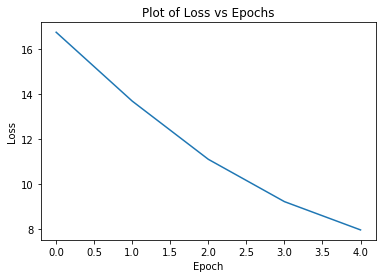

In [22]:
plt.plot(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Epochs')
plt.show()

In [23]:
model

Resnet18Multiclass(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### Load the best model (based on validation set) and evaluate on test set

In [24]:
#RERUN
#model = load_model(model_save + 'model_backup.pt')#'best.model')
#model_save
#torch.save(model.state_dict(), model_save + "model_backup.pt")
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [25]:
prediction_dataset.df

,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Turdus leucomelas,Celeus grammicus,Zonotrichia capensis,Thraupis episcopus,Trogon viridis,Myioborus miniatus,other,Microcerculus marginatus,Ramphastos tucanus
file,,,,,,,,,,,
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_9.0s_9.299591836734693s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC101469 - Pale-breasted Thrush - Turdus leucomelas.wav_0.0s_3.0s.wav,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC97542 - Slate-throated Whitestart - Myioborus miniatus.wav_3.0s_4.362448979591837s.wav,0,0,0,0,0,0,0,1,0,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_0.0s_3.0s.wav,0,0,0,0,1,0,0,0,0,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_3.0s_6.0s.wav,0,0,0,0,1,0,0,0,0,0,0


In [26]:
model_save

'C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/model/automated_cosmos_tweety_to_file_warblar_no_bird_test_4_5_epochs/'

In [27]:
prediction_dataset.df = prediction_dataset.df[list(model.classes)]

In [28]:
list(model.classes)

['Xiphorhynchus guttatus',
 'Tolmomyias sulphurescens',
 'Turdus leucomelas',
 'Celeus grammicus',
 'Zonotrichia capensis',
 'Thraupis episcopus',
 'Trogon viridis',
 'Myioborus miniatus',
 'other',
 'Microcerculus marginatus',
 'Ramphastos tucanus']

In [29]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=6,
                                                                 activation_layer='softmax')

(6974, 11)


#### Print various metrics for the test set predictions

In [30]:
valid_labels_df

,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Turdus leucomelas,Celeus grammicus,Zonotrichia capensis,Thraupis episcopus,Trogon viridis,Myioborus miniatus,other,Microcerculus marginatus,Ramphastos tucanus
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_9.0s_9.299591836734693s.wav,0,0,0,0,0,0,0,0,1,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC101469 - Pale-breasted Thrush - Turdus leucomelas.wav_0.0s_3.0s.wav,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC97542 - Slate-throated Whitestart - Myioborus miniatus.wav_3.0s_4.362448979591837s.wav,0,0,0,0,0,0,0,1,0,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_0.0s_3.0s.wav,0,0,0,0,1,0,0,0,0,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_3.0s_6.0s.wav,0,0,0,0,1,0,0,0,0,0,0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_6.0s_9.0s.wav,0,0,0,0,1,0,0,0,0,0,0


In [31]:
valid_preds_df

,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Turdus leucomelas,Celeus grammicus,Zonotrichia capensis,Thraupis episcopus,Trogon viridis,Myioborus miniatus,other,Microcerculus marginatus,Ramphastos tucanus
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_6.0s_9.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_9.0s_9.299591836734693s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC101469 - Pale-breasted Thrush - Turdus leucomelas.wav_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC97542 - Slate-throated Whitestart - Myioborus miniatus.wav_3.0s_4.362448979591837s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_0.0s_3.0s.wav,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_6.0s_9.0s.wav,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
valid_scores_df

,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Turdus leucomelas,Celeus grammicus,Zonotrichia capensis,Thraupis episcopus,Trogon viridis,Myioborus miniatus,other,Microcerculus marginatus,Ramphastos tucanus
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_0.0s_3.0s.wav,7.501860e-11,4.780936e-09,3.821599e-07,1.399043e-10,0.999999,1.163849e-07,1.539893e-10,2.238701e-07,3.846014e-07,1.083843e-09,1.552821e-12
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_3.0s_6.0s.wav,1.974170e-13,2.003212e-11,5.365541e-10,6.909140e-13,1.000000,3.317308e-08,1.435004e-12,7.894762e-09,3.765660e-09,8.975902e-12,3.818272e-15
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_6.0s_9.0s.wav,2.551666e-11,4.381021e-10,4.211199e-08,3.048508e-11,1.000000,1.823934e-07,5.294728e-11,1.832882e-08,3.621649e-08,3.316582e-10,6.986914e-13
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.wav_9.0s_9.299591836734693s.wav,2.784342e-03,2.273418e-01,7.475540e-02,9.722546e-03,0.009579,2.997526e-02,1.613208e-03,1.556018e-01,4.773724e-01,1.118965e-02,6.490436e-05
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC101469 - Pale-breasted Thrush - Turdus leucomelas.wav_0.0s_3.0s.wav,1.680605e-04,3.022410e-01,1.481887e-01,4.257402e-04,0.000009,1.398815e-03,2.689443e-06,7.941701e-04,5.467382e-01,2.559740e-05,8.351765e-06
...,...,...,...,...,...,...,...,...,...,...,...
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC97542 - Slate-throated Whitestart - Myioborus miniatus.wav_3.0s_4.362448979591837s.wav,5.848605e-03,3.162635e-01,3.093806e-02,5.482427e-02,0.004229,1.925300e-02,3.292634e-03,2.517678e-03,5.429099e-01,1.902599e-02,8.972754e-04
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_0.0s_3.0s.wav,3.311174e-03,6.632891e-02,4.116604e-01,5.229776e-03,0.007631,1.563005e-03,2.126091e-04,3.521941e-01,1.511867e-01,6.523011e-04,2.976014e-05
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_3.0s_6.0s.wav,5.938694e-04,4.088750e-02,6.043074e-02,4.900990e-04,0.373683,3.054043e-02,3.784202e-04,3.606966e-01,1.321331e-01,1.582890e-04,8.049348e-06
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/temp_clips/Testing_Cosmos/XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.wav_6.0s_9.0s.wav,6.690607e-05,6.950141e-01,8.844189e-03,1.203853e-04,0.075199,3.678417e-03,2.567905e-04,6.541755e-04,2.160115e-01,1.506038e-04,3.766491e-06


In [33]:
print(classification_report(valid_labels_df, valid_scores_df.apply(round), target_names=valid_scores_df.columns))

                          precision    recall  f1-score   support

  Xiphorhynchus guttatus       0.40      0.47      0.44       390
Tolmomyias sulphurescens       0.46      0.65      0.54       376
       Turdus leucomelas       0.53      0.49      0.51       511
        Celeus grammicus       0.10      0.93      0.18       165
    Zonotrichia capensis       0.48      0.55      0.52       414
      Thraupis episcopus       0.25      0.64      0.36       226
          Trogon viridis       0.63      0.53      0.58       426
      Myioborus miniatus       0.38      0.61      0.47       407
                   other       0.47      0.02      0.04      3166
Microcerculus marginatus       0.44      0.57      0.50       346
      Ramphastos tucanus       0.71      0.85      0.77       547

               micro avg       0.38      0.35      0.36      6974
               macro avg       0.44      0.57      0.44      6974
            weighted avg       0.48      0.35      0.30      6974
        

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot the RIC curve and report AOC

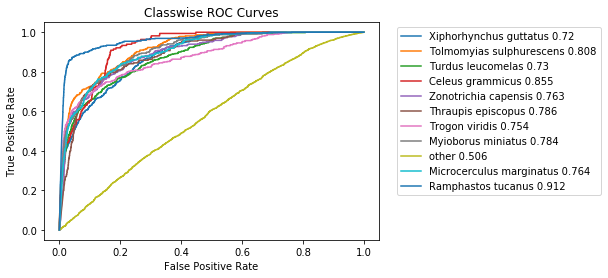

In [34]:

for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
    plt.plot(fpr,tpr,label= species + " "+str(round(auc, 3)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [35]:
model.classes

['Xiphorhynchus guttatus',
 'Tolmomyias sulphurescens',
 'Turdus leucomelas',
 'Celeus grammicus',
 'Zonotrichia capensis',
 'Thraupis episcopus',
 'Trogon viridis',
 'Myioborus miniatus',
 'other',
 'Microcerculus marginatus',
 'Ramphastos tucanus']

***Validate Results***

In [36]:
model.predict

<bound method PytorchModel.predict of Resnet18Multiclass(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64

In [37]:
model.train_dataset.sample(n=0)

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
valid_labels_df[species].values.shape

(6974,)

In [40]:
test = valid_preds_df.apply(lambda x: sum(x) == 1, axis=1)
test[~test]

Series([], dtype: bool)

In [41]:
def label(row):
    for col in row:
        print(row[col])
        if row[col] == 1:
            row[col] = col
    return row

In [42]:
def label(row):
    for col in range(len(valid_labels_df.columns)):
        if row[col] == 1:
            return valid_labels_df.columns[col]

label_confusion = pd.DataFrame(valid_labels_df.apply(label, axis=1))
preds_confusion = pd.DataFrame(valid_preds_df.apply(label, axis=1))

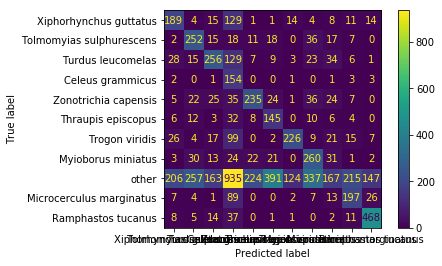

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(label_confusion, preds_confusion,labels=valid_scores_df.columns)
cm_display = ConfusionMatrixDisplay(cm, display_labels=valid_scores_df.columns).plot()

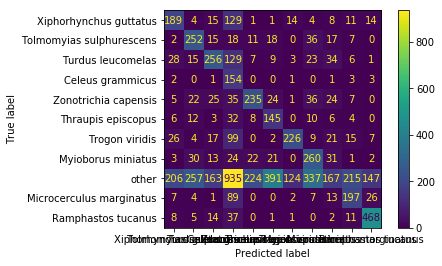

In [44]:
ConfusionMatrixDisplay.from_predictions(label_confusion, preds_confusion,labels=valid_scores_df.columns)

In [45]:
import itertools
def plot_confusion_matrix_2(cm,
                      target_names,
                      title='Tweetynet WTS on Opensoundscape with Mixed Bird Other',
                      cmap=None,
                      normalize=True,
                      FONT_SIZE = 10,
                      figsize = (8*2, 6*2)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions


    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://stackoverflow.com/questions/48855290/plotted-confusion-matrix-values-overlapping-each-other-total-classes-90

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)    # 8, 6
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
        plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

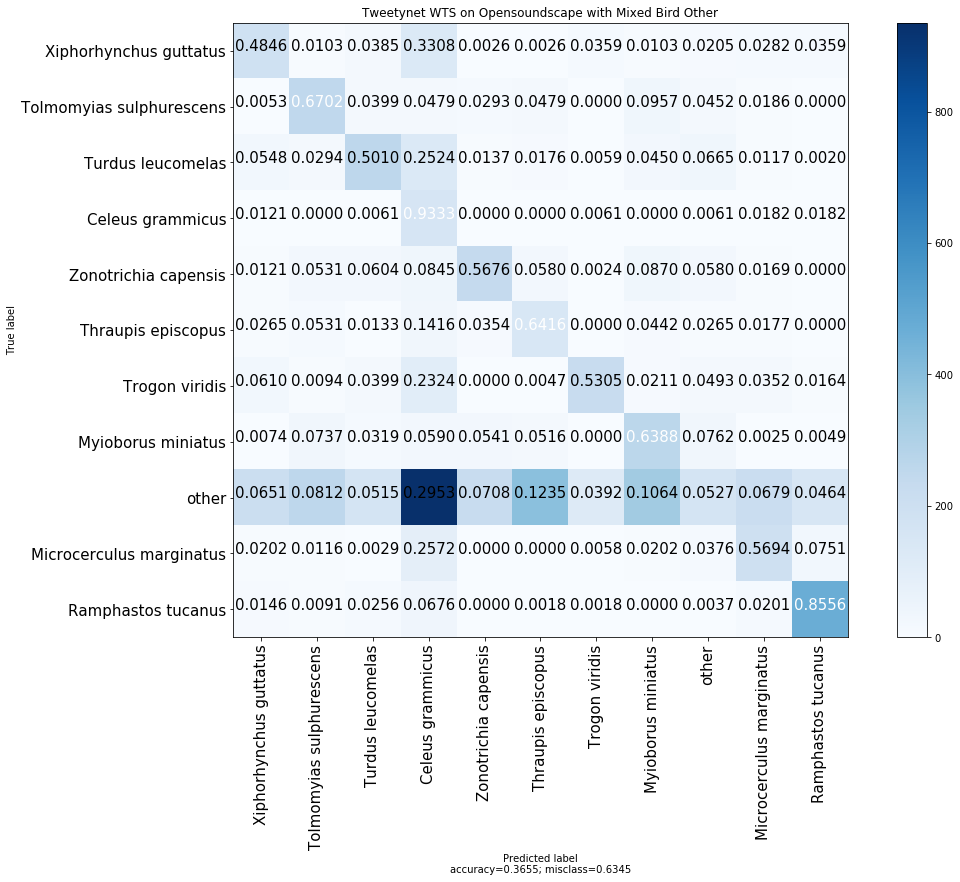

In [46]:
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15)